# Exercise 1
## Part 2. NumPy Implementation for Network Training

Architecture
1. Linear layer: implementation of backward and forward passes and parameter update
2. Tanh activation function: implementation of backward and forward passes
3. Multilayer Perceptron (MLP): building the model architecture by combining Linear and Tanh layers
4. Mean Squared Error Loss: computation of the loss and its gradients with respect to the model's output
5. Training loop: no implementation is required


<div style="text-align: center;">
    <figure>
        <img src="ex1_graph_01-3.png" alt="Image Title" style="width:900px; height:auto;"/>
        <figcaption>Figure 1: Forward and Backward Pass in the MLP</figcaption>
    </figure>
</div>


In [1]:
# Import libraries

import matplotlib.pyplot as plt
import numpy as np

from IPython import display

In [2]:
# Network class
class Linear:
    def __init__(self, input_dim, output_dim, initial_weights=None, initial_biases=None):
        """
        Initialize weights and biases
        
        Args:
        - input_dim (int): Number of input features.
        - output_dim (int): Number of output features.
        - initial_weights (np.array): Initial weights of shape (output_dim, input_dim).
        - initial_biases (np.array): Initial biases of shape (output_dim,).
        """
        if initial_weights is None: initial_weights = np.random.randn(output_dim, input_dim)
        if initial_biases is None: initial_biases = np.random.randn(output_dim)
        self.weights = initial_weights
        self.biases = initial_biases
        
    def forward(self, x):
        """
        Compute the linear transformation
        
        Args:
        - x (np.array): Input data of shape (num_samples, input_dim).
        
        Returns:
        - output (np.array): Output data of shape (num_samples, output_dim).
        """
        self.x = x # Store this for backward pass

        # Compute forward pass
        self.output = np.dot(self.x, self.weights.T) + self.biases
        return self.output
    
    def backward(self, grad_output):
        """
        Perform the backward pass of the Linear layer.
        
        Args:
        - grad_output (np.array): Gradient of the loss with respect to the output with shape (num_samples, output_dim).
        
        Returns:
        - grad_input (np.array): Gradient of the loss with respect to the input with shape (num_samples, input_dim).
        """
        # Compute self.grad_weights, self.grad_biases, self.grad_input 
        assert hasattr(self, 'x'), 'Perform forward pass first.'

        self.grad_weights = np.dot(grad_output.T, self.x) # Gradient of loss w.r.t. weights
        self.grad_biases = np.sum(grad_output, axis=0) # Gradient of loss w.r.t. biases
        self.grad_input = np.dot(grad_output, self.weights) # Gradient of loss w.r.t. input
        
        return self.grad_input
    
    def update_params(self, learning_rate):
        """
        Update the weights and biases using the calculated gradients.
        
        Args:
        - learning_rate (float): Learning rate for updating parameters.
        """
        # Update parameters using calculated gradients
        self.weights -= learning_rate * self.grad_weights
        self.biases -= learning_rate * self.grad_biases


In [3]:
# Activation function
class Tanh:
    def forward(self, x):
        """
        Apply the Tanh activation function.
        
        Args:
        - x (np.array): Input data of shape (num_samples, input_dim).
        
        Returns:
        - output (np.array): Activated output data of shape (num_samples, input_dim).
        """
        self.x = x # Keep this for backward computation

        # Compute forward pass
        self.output = np.tanh(self.x)
        return self.output
    
    def backward(self, grad_output):
        """
        Compute the gradient of the loss with respect to the input of Tanh.
        
        Args:
        - grad_output (np.array): Gradient of the loss with respect to the output.
        
        Returns:
        - grad_input (np.array): Gradient of the loss with respect to the input.
        """
        assert hasattr(self, 'x'), 'Perform forward pass first.'

        # Compute the gradient of the loss w.r.t. the input
        self.grad_input = grad_output * (1 - np.tanh(self.x)**2)
        return self.grad_input

In [4]:
# Create the MLP
class MLP:
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Initialize the MLP with the necessary layers.
        
        Args:
        - input_dim (int): Number of input features.
        - hidden_dim (int): Number of units in the hidden layer.
        - output_dim (int): Number of units in the output layer.
        """
        # Initialize the linear layers and activation function
        self.linear1 = Linear(input_dim, hidden_dim)
        self.activation = Tanh()
        self.linear2 = Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        """
        Forward pass through the MLP.
        
        Args:
        - x (np.array): Input data.
        
        Returns:
        - output (np.array): Output of the MLP.
        """
        hidden = self.linear1.forward(x)
        activated_hidden = self.activation.forward(hidden) 
        output = self.linear2.forward(activated_hidden)
        return output
    
    def backward(self, grad_output):
        """
        Backward pass through the MLP.
        
        Args:
        - grad_output (np.array): Gradient of the loss with respect to the MLP output.
        
        Returns:
        - grad_input (np.array): Gradient of the loss with respect to the MLP input.
        """
        self.linear2.backward(grad_output)
        self.activation.backward(self.linear2.grad_input)
        self.linear1.backward(self.activation.grad_input)
        grad_input = self.linear1.grad_input
        return grad_input
    
    def update_params(self, learning_rate):
        """
        Update the parameters of the MLP.
        
        Args:
        - learning_rate (float): Learning rate for parameter updates.
        """
        # Update the parameters of each linear layer
        self.linear1.update_params(learning_rate)
        self.linear2.update_params(learning_rate)

In [5]:
# Loss function
class MSELoss:
    def forward(self, y, t):
        """
        Compute the mean squared error loss.
        
        Args:
        - y (np.array): Predicted values.
        - t (np.array): True values.
        
        Returns:
        - loss (float): Computed MSE loss.
        """        
        # ! Store inputs as class attribute to prevent any changes between two passes
        self.y = y
        self.t = t
        loss = np.mean((y-t)**2)
        return loss
    
    def backward(self):
        """
        Compute the gradient of the loss with respect to the predicted output.
        
        Returns:
        - grad_input (np.array): Gradient of the loss with respect to the predicted output.
        """
        self.grad_input = 2 * (self.y - self.t) / self.y.size
        return self.grad_input

In [6]:
# Generate random data (in this case mimicking a quadratic function)
def generate_data(num_samples=100):
    np.random.seed(4)
    x = np.linspace(-1, 1, num_samples)
    noise = np.random.randn(x.shape[0]) * 0.2
    y = 2 * x**2 + 3 + noise
    
    x = np.expand_dims(x,1)
    y = np.expand_dims(y,1)
    
    return x, y

In [7]:
update_plot = True # This will be used to visualize your training loss curve over epochs

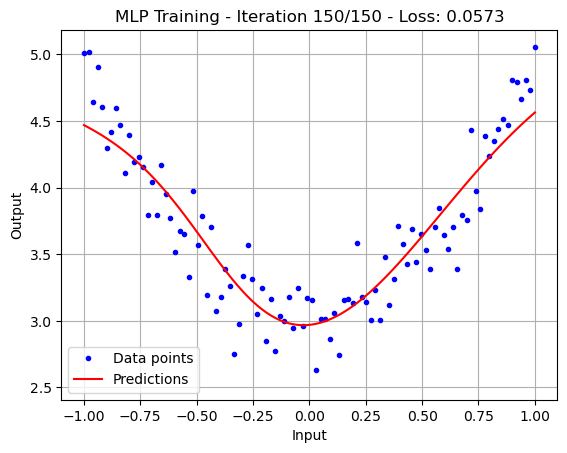

In [8]:
# Hyperparameters
input_dim = 1
hidden_dim = 10
output_dim = 1
learning_rate = 0.1
epochs = 150

# Initialize the MLP model and MSE Loss function
mlp = MLP(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
mse_loss = MSELoss()

# Generate data
x, y_train = generate_data()

# Plot setup
fig, ax = plt.subplots()
ax.plot(x, y_train, 'b.', label='Data points')  # Plot the original data
line1, = ax.plot(x, np.full_like(y_train, min(y_train) - 0.1), 'r-', label='Predictions')
ax.grid(True)
ax.set_title(f'MLP Training - Iteration 0/{epochs}')
ax.set_xlabel('Input')
ax.set_ylabel('Output')
plt.legend()

# Training loop
losses = []
for epoch in range(epochs):
    # Forward pass
    y_pred = mlp.forward(x)

    # Compute loss
    loss = mse_loss.forward(y_pred, y_train)
    losses.append(loss)
    
    # Gradients
    grad_loss = mse_loss.backward()
    mlp.backward(grad_loss)
    mlp.update_params(learning_rate)

    if update_plot:
        # Update the plot 
        line1.set_ydata(y_pred) 
        ax.set_title(f'MLP Training - Iteration {epoch + 1}/{epochs} - Loss: {loss:.4f}')
        plt.pause(0.05)  
        display.clear_output(wait=True)
        display.display(fig)
        
display.clear_output(wait=True)
plt.show()
assert loss.item() < 0.15, 'Loss is too high, check your implementation.'